In [11]:
import os
import sys

import numpy as np
import pandas as pd
# import pandas_datareader.data as web

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

# import lightgbm as lgb
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# from prophet import Prophet
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.compose import (TransformedTargetForecaster,
                                        make_reduction)
from sktime.forecasting.model_selection import (ExpandingWindowSplitter,
                                                ForecastingGridSearchCV)
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

sns.set()
plt.style.use('bmh')

In [12]:
df = pd.read_csv('air-traffic-prediction/parkingLot.csv')
df

,vehicle_no,timestamp,camera_id
0,MHUN7063,2024-09-12 05:00:00,1
1,MHYN4677,2024-09-12 05:00:00,1
2,MHEL6595,2024-09-12 05:00:00,1
3,MHNQ2590,2024-09-12 05:00:00,1
4,MHHA0518,2024-09-12 05:00:00,1
...,...,...,...
106689,MHCN7114,2024-11-14 00:00:00,2
106690,MHVY8418,2024-11-14 00:00:00,2
106691,MHSR8102,2024-11-14 00:00:00,2
106692,MHQG5264,2024-11-14 00:00:00,2


In [13]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by='timestamp')
df = df[df['vehicle_no'].notna()]
df = df[(df['timestamp'].dt.hour >= 5) & (df['timestamp'].dt.hour < 24)]
df = df.drop_duplicates()
df

,vehicle_no,timestamp,camera_id
0,MHUN7063,2024-09-12 05:00:00,1
21,MHMY1867,2024-09-12 05:00:00,1
20,MHZF8417,2024-09-12 05:00:00,1
19,MHFU6425,2024-09-12 05:00:00,1
18,MHHB4038,2024-09-12 05:00:00,1
...,...,...,...
106658,MHPB1713,2024-11-13 23:40:00,2
106657,MHRN1774,2024-11-13 23:40:00,2
106656,MHNN2256,2024-11-13 23:40:00,2
106655,MHBU1695,2024-11-13 23:40:00,2


In [14]:
entry_df = df[df['camera_id'] == 1]  # Entries (camera_id = 001)
exit_df = df[df['camera_id'] == 2]   # Exits (camera_id = 002)

# 2. Rename columns for clarity
entry_df = entry_df.rename(columns={'timestamp': 'in_time'})
exit_df = exit_df.rename(columns={'timestamp': 'exit_time'})
merged_df = pd.merge(entry_df[['vehicle_no', 'in_time']], 
                     exit_df[['vehicle_no', 'exit_time']], 
                     on='vehicle_no', 
                     how='left')

# 4. Preview the new DataFrame with in_time and exit_time
print(merged_df.head())
merged_df

  vehicle_no             in_time           exit_time
0   MHUN7063 2024-09-12 05:00:00 2024-09-12 08:00:00
1   MHMY1867 2024-09-12 05:00:00 2024-09-12 09:20:00
2   MHZF8417 2024-09-12 05:00:00 2024-09-12 09:20:00
3   MHFU6425 2024-09-12 05:00:00 2024-09-12 09:40:00
4   MHHB4038 2024-09-12 05:00:00 2024-09-12 09:20:00


,vehicle_no,in_time,exit_time
0,MHUN7063,2024-09-12 05:00:00,2024-09-12 08:00:00
1,MHMY1867,2024-09-12 05:00:00,2024-09-12 09:20:00
2,MHZF8417,2024-09-12 05:00:00,2024-09-12 09:20:00
3,MHFU6425,2024-09-12 05:00:00,2024-09-12 09:40:00
4,MHHB4038,2024-09-12 05:00:00,2024-09-12 09:20:00
...,...,...,...
53318,MHPN3450,2024-11-13 20:00:00,NaT
53319,MHBB9719,2024-11-13 20:00:00,NaT
53320,MHQJ4009,2024-11-13 20:00:00,NaT
53321,MHDF3718,2024-11-13 20:00:00,NaT


In [15]:
# Remove rows with NaN values in the merged DataFrame
cleaned_df = merged_df.dropna()

# Preview the cleaned DataFrame
print(cleaned_df.head())

# Display the cleaned DataFrame
cleaned_df


  vehicle_no             in_time           exit_time
0   MHUN7063 2024-09-12 05:00:00 2024-09-12 08:00:00
1   MHMY1867 2024-09-12 05:00:00 2024-09-12 09:20:00
2   MHZF8417 2024-09-12 05:00:00 2024-09-12 09:20:00
3   MHFU6425 2024-09-12 05:00:00 2024-09-12 09:40:00
4   MHHB4038 2024-09-12 05:00:00 2024-09-12 09:20:00


,vehicle_no,in_time,exit_time
0,MHUN7063,2024-09-12 05:00:00,2024-09-12 08:00:00
1,MHMY1867,2024-09-12 05:00:00,2024-09-12 09:20:00
2,MHZF8417,2024-09-12 05:00:00,2024-09-12 09:20:00
3,MHFU6425,2024-09-12 05:00:00,2024-09-12 09:40:00
4,MHHB4038,2024-09-12 05:00:00,2024-09-12 09:20:00
...,...,...,...
53311,MHBU1695,2024-11-13 19:20:00,2024-11-13 23:40:00
53312,MHFL6897,2024-11-13 19:20:00,2024-11-13 23:40:00
53313,MHFO0975,2024-11-13 19:20:00,2024-11-13 23:40:00
53314,MHSY4044,2024-11-13 19:40:00,2024-11-13 23:40:00


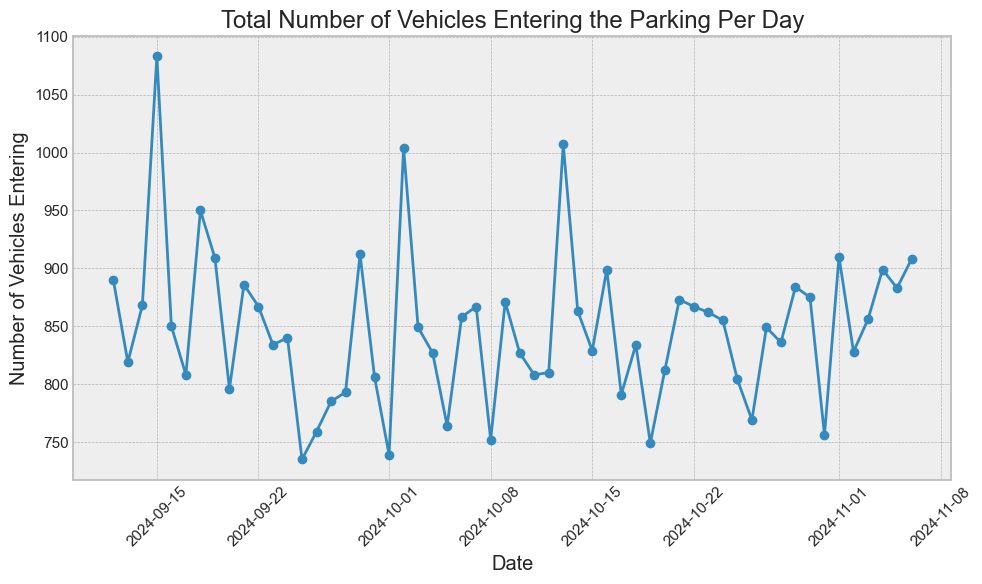

date
2024-11-07    809
2024-11-08    801
2024-11-09    874
2024-11-10    948
2024-11-11    832
2024-11-12    813
2024-11-13    782
Name: vehicle_no, dtype: int64


In [16]:
import matplotlib.pyplot as plt

# Ensure 'in_time' is in datetime format
merged_df['in_time'] = pd.to_datetime(merged_df['in_time'])

# 1. Extract the date from the 'in_time' column
merged_df['date'] = merged_df['in_time'].dt.date

# 2. Group by 'date' and count the number of entries per day
entries_daily = merged_df.groupby('date')['vehicle_no'].count()


# Sort the data by date (this step ensures it's chronological)
entries_daily = entries_daily.sort_index()

# 1. Split the data into train and test sets
# Use all but the last 7 days for training, and the last 7 days for testing
train_data = entries_daily.iloc[:-7]  # All data except the last 7 days
test_data = entries_daily.iloc[-7:] 

# 3. Plot the total number of vehicles entering per day
plt.figure(figsize=(10, 6))
train_data.plot(kind='line', marker='o')
plt.title('Total Number of Vehicles Entering the Parking Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles Entering')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()
plt.show()
print(test_data)

In [17]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
import matplotlib.pyplot as plt

# Step 1: Fit AutoARIMA model on the train data
model_auto_arima = AutoARIMA(sp=1, suppress_warnings=True)  # sp=1 assumes no seasonality, adjust if needed
model_auto_arima.fit(train_data)

# Step 2: Forecast the next 7 days (same length as test_data)
forecast_auto_arima = model_auto_arima.predict(fh=[i for i in range(1, 8)])

# Step 3: Calculate MAPE and MASE
mape_score = mean_absolute_percentage_error(test_data, forecast_auto_arima)
mase_score = mean_absolute_scaled_error(test_data, forecast_auto_arima, train_data)

# Step 4: Plot the forecasted vs actual values
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data, label="Training Data")
plt.plot(test_data.index, test_data, label="Actual Test Data", color='orange')
plt.plot(test_data.index, forecast_auto_arima, label="Forecasted Data", color='green', linestyle='--')
plt.title('Auto ARIMA Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles Entering')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the forecasted values for the next 7 days
print("Forecasted values for the next 7 days using Auto ARIMA:")
print(forecast_auto_arima)

# Print the MAPE and MASE scores
print(f"MAPE: {mape_score}")
print(f"MASE: {mase_score}")


TypeError: Unsupported input data type in AutoARIMA, input y must be in an sktime compatible format. Allowed scitypes for y in forecasting are Series, Panel, Hierarchical, for instance a pandas.DataFrame with sktime compatible time indices, or with MultiIndex and last(-1) level an sktime compatible time index. See the forecasting tutorial examples/01_forecasting.ipynb, or the data format tutorial examples/AA_datatypes_and_datasets.ipynb See the data format tutorial examples/AA_datatypes_and_datasets.ipynb. If you think the data is already in an sktime supported input format, run sktime.datatypes.check_raise(data, mtype) to diagnose the error, where mtype is the string of the type specification you want. Error message for checked mtypes, in format [mtype: message], as follows: [pd_multiindex_hier: y must be a pd.DataFrame, found <class 'pandas.core.series.Series'>]  [df-list: y must be list of pd.DataFrame, found <class 'pandas.core.series.Series'>]  [nested_univ: y must be a pd.DataFrame, found <class 'pandas.core.series.Series'>]  [numpy3D: y must be a numpy.ndarray, found <class 'pandas.core.series.Series'>]  [pd-multiindex: y must be a pd.DataFrame, found <class 'pandas.core.series.Series'>]  [np.ndarray: y must be a numpy.ndarray, found <class 'pandas.core.series.Series'>]  [pd.DataFrame: y must be a pandas.DataFrame, found <class 'pandas.core.series.Series'>]  [pd.Series: <class 'pandas.core.indexes.base.Index'> is not supported for y, use one of (<class 'pandas.core.indexes.range.RangeIndex'>, <class 'pandas.core.indexes.period.PeriodIndex'>, <class 'pandas.core.indexes.datetimes.DatetimeIndex'>) or integer index instead.] 

c:\Users\aditi\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


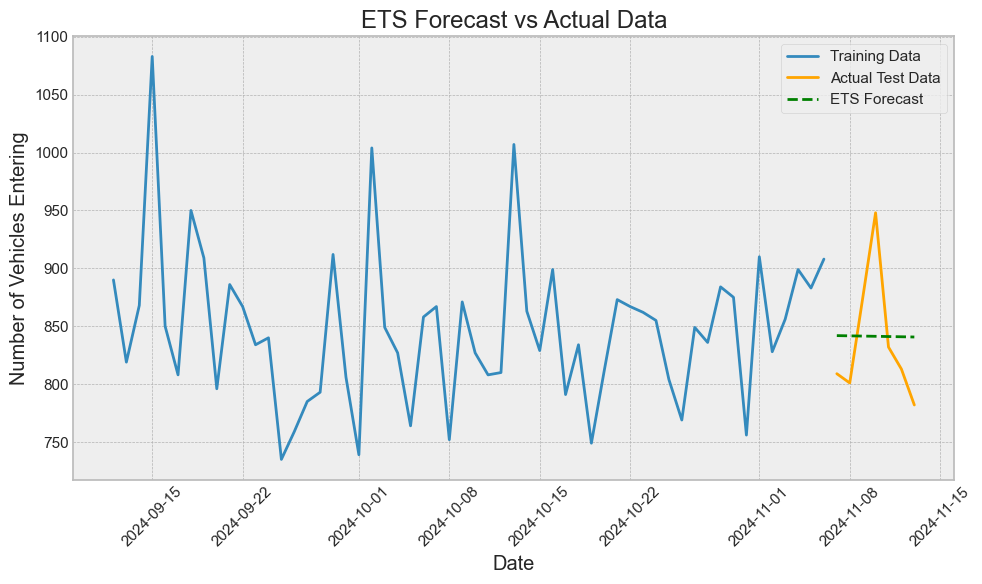

ETS Forecasted values for the next 7 days:
2024-11-07    841.902906
2024-11-08    841.704002
2024-11-09    841.505098
2024-11-10    841.306194
2024-11-11    841.107290
2024-11-12    840.908386
2024-11-13    840.709481
Freq: D, dtype: float64


In [32]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Step 1: Fit ETS model on the training data
model_ets = ExponentialSmoothing(train_data, trend='add', seasonal=None)
model_ets_fit = model_ets.fit()

# Step 2: Forecast the next 7 days using the ETS model
forecast_ets = model_ets_fit.forecast(steps=7)

# Plot the ETS forecast vs actual
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data, label="Training Data")
plt.plot(test_data.index, test_data, label="Actual Test Data", color='orange')
plt.plot(test_data.index, forecast_ets, label="ETS Forecast", color='green', linestyle='--')
plt.title('ETS Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles Entering')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print forecasted values
print("ETS Forecasted values for the next 7 days:")
print(forecast_ets)


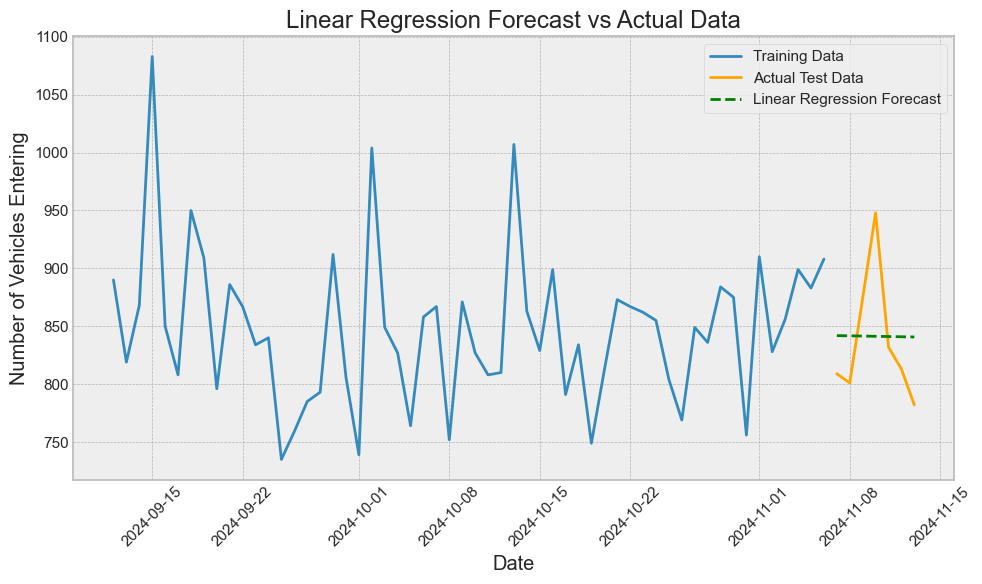

Linear Regression Forecasted values for the next 7 days:
[841.90649351 841.70772386 841.5089542  841.31018455 841.1114149
 840.91264525 840.7138756 ]


In [33]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Create time index as a numerical variable (e.g., number of days)
time_index = np.arange(len(train_data)).reshape(-1, 1)
time_test_index = np.arange(len(train_data), len(train_data) + 7).reshape(-1, 1)

# Step 1: Fit Linear Regression on the training data
linear_model = LinearRegression()
linear_model.fit(time_index, train_data)

# Step 2: Forecast for the next 7 days using Linear Regression
forecast_lr = linear_model.predict(time_test_index)

# Plot the Linear Regression forecast vs actual
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data, label="Training Data")
plt.plot(test_data.index, test_data, label="Actual Test Data", color='orange')
plt.plot(test_data.index, forecast_lr, label="Linear Regression Forecast", color='green', linestyle='--')
plt.title('Linear Regression Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles Entering')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print forecasted values
print("Linear Regression Forecasted values for the next 7 days:")
print(forecast_lr)


In [34]:
# Define the MASE calculation
def mase(actual, forecast, train_data):
    mae_train = np.mean(np.abs(np.diff(train_data)))  # In-sample MAE for scaling
    mae_forecast = np.mean(np.abs(actual - forecast))
    return mae_forecast / mae_train

# Define the MAPE calculation
def mape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

mase_arima=mase(test_data.values, forecast_arima,train_data.values)
mape_arima=mape(test_data.values,forecast_arima)
# Calculate MASE and MAPE for ETS model
mase_ets = mase(test_data.values, forecast_ets, train_data.values)
mape_ets = mape(test_data.values, forecast_ets)

# Calculate MASE and MAPE for Linear Regression model
mase_lr = mase(test_data.values, forecast_lr, train_data.values)
mape_lr = mape(test_data.values, forecast_lr)

# Report the results
print(f"ARIMA Model - MASE: {mase_arima}, MAPE: {mape_arima}%")
print(f"ETS Model - MASE: {mase_ets}, MAPE: {mape_ets}%")
print(f"Linear Regression Model - MASE: {mase_lr}, MAPE: {mape_lr}%")


ARIMA Model - MASE: 0.9489421418672785, MAPE: 8.269815766963186%
ETS Model - MASE: 0.6149395715582927, MAPE: 5.1651896940929625%
Linear Regression Model - MASE: 0.6149639700468832, MAPE: 5.165422198785792%
